In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [2]:
import time
import random
import warnings
from multiprocessing import cpu_count
from itertools import chain
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import ray
from dask.distributed import Client

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
# from gensim.models import Word2Vec

from processing.utils import CleanUp, SNOWBALL_STEMMER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [3]:
ray.shutdown()
ray.init(num_cpus=cpu_count(), include_webui=False, lru_evict=True)

2020-06-03 17:10:54,754	INFO resource_spec.py:204 -- Starting Ray with 5.57 GiB memory available for workers and up to 2.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.8.1.29',
 'raylet_ip_address': '10.8.1.29',
 'redis_address': '10.8.1.29:53558',
 'object_store_address': '/tmp/ray/session_2020-06-03_17-10-54_749562_10362/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-03_17-10-54_749562_10362/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-06-03_17-10-54_749562_10362'}

In [4]:
corpus = []

filename = f"{os.getcwd()}/../../data/embedding/corpus.txt"
file_it = pd.read_csv(filename, header=None, iterator=True, names=["sentence"], chunksize=5000,)

@ray.remote
def carregar_frases(lines):
    import os
    import sys

    sys.path.append(f"{os.getcwd()}/../")
    from processing.utils import CleanUp, SNOWBALL_STEMMER
    clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)
    
    lines = lines["sentence"].tolist()
    return [clean_up.fit(line) for line in lines]

# itera = []
# i = 0
# for lines in file_it:
#     itera.append(lines)
#     if i == 5:
#         break
#     i += 1
corpus = list(chain(*ray.get([carregar_frases.remote(lines) for lines in file_it])))

ray.shutdown()

In [5]:
len(corpus)

723031

In [6]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [7]:
print(random.choice(textos))
print(len(textos))

for item in list(textos[:, 0]):
    corpus.append(item)
# corpus += textos[:, 0]
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['respost tribunadonort alinh isso publiqu decret que dev procur unidad hospital apen moment que pacient estiv com falt vai dar sup cert'
 0]
2309


In [8]:
# class Word2VecVectorizer(TransformerMixin, BaseEstimator):
    
#     def __init__(self):
#         self.w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
#         # print(f"Palavras no vocab: {len(list(self.w2v.wv.vocab))}")
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         n_textos = []
#         for texto in X:
#             doc = []
#             for palavra in texto.split():
#                 try:
#                     doc.append(self.w2v.wv[palavra])
#                 except:
#                     doc.append(np.zeros(300, ))
#             n_textos.append(np.mean(doc, axis=0))
#         return StandardScaler().fit_transform(np.asarray(n_textos)) 
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)

In [9]:
# w2v = Word2VecVectorizer()
# sgd_w2v = SGDClassifier(
#     alpha=1e-7,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=3000,
#     n_iter_no_change=50
# )

# pipe = make_pipeline(w2v, sgd_w2v)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# pipe.fit(X_train, y_train)
# pred = pipe.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [10]:
validacoes, N = [], 7
for ngram_range in zip(np.ones((N), dtype=np.int), range(1, N)):
    acc, f1 = [], []
    tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)
    for _ in range(5):
        clf = SVC(kernel="linear", C=5)
        pipe = make_pipeline(tfidf, clf)

        X = textos[:, 0]
        y = textos[:, 1].astype(np.int).ravel()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)

        acc.append(round(accuracy_score(pred, y_test) * 100, 2))
        f1.append(round(f1_score(pred, y_test) * 100, 2))

    validacoes.append((
        ngram_range,
        round(np.mean(acc), 2),
        np.max(acc),
        round(np.mean(f1), 2),
        np.max(f1)
    ))

In [11]:
columns = ["NGram", "Accuracy", "Acc Max.", "F1", "F1 Max."]
df = pd.DataFrame(validacoes, columns=columns)
df = df.sort_values(by=["F1 Max.", "Acc Max.", "NGram"], ascending=False)
ngram_range = df.reset_index().loc[0]["NGram"]
df.head(25)

,NGram,Accuracy,Acc Max.,F1,F1 Max.
3,"(1, 4)",76.02,78.79,71.94,75.62
4,"(1, 5)",74.63,76.62,71.52,75.23
5,"(1, 6)",74.15,76.84,71.77,74.58
2,"(1, 3)",74.59,76.19,70.53,73.49
1,"(1, 2)",74.94,76.41,69.02,72.41
0,"(1, 1)",73.94,75.54,67.69,69.79


## Modelo final selecionado

In [12]:
print(f"NGram escolhido: {ngram_range}")
tfidf = TfidfVectorizer(ngram_range=ngram_range, lowercase=False).fit(corpus)

NGram escolhido: (1, 4)


Cross Validation accuracy: 0.75 (+/- 0.05)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       271
           1       0.73      0.76      0.74       191

    accuracy                           0.78       462
   macro avg       0.78      0.78      0.78       462
weighted avg       0.79      0.78      0.78       462



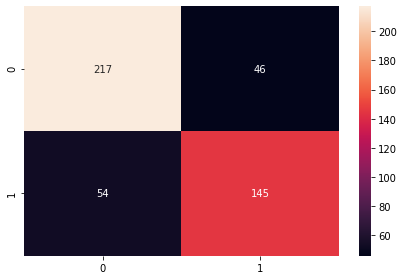

In [13]:
clf = SVC(kernel="linear", C=5, random_state=0)

pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe.fit(X_train, y_train)

scores = cross_val_score(pipe, X_train, y_train, cv=5)
print("Cross Validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()

pred = pipe.predict(X_test)
print(classification_report(y_test, pred))
df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [14]:
# params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'alpha': [1e-1, 1e-3, 1e-5, 1e-7],
#     'max_iter': [500, 1000, 2000, 3000],
#     'n_iter_no_change': [10, 25, 50]
# }

# clf = make_pipeline(tfidf, 
#                     GridSearchCV(SGDClassifier(random_state=0, n_jobs=-1,),
#                                  params,
#                                  cv=5,
#                                  refit=True, n_jobs=-1))

# params = {
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.5, 1, 5, 10],
#     'tol': [1e-1, 1e-2, 1e-3, 1e-4],
#     'decision_function_shape': ['ovo', 'ovr']
# }

# cv = GridSearchCV(SVC(random_state=0), params, refit=True, n_jobs=-1)
# clf = make_pipeline(tfidf, cv)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [15]:
# clf1 = make_pipeline(w2v, sgd_w2v)
# clf2 = make_pipeline(tfidf, sgd_tfidf)

# eclf = VotingClassifier(
#     estimators=[('w2v', clf1), ('tfidf', clf2)],
#     voting='hard', weights=[1, 1], n_jobs=-1
# )

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# eclf.fit(X_train, y_train)
# pred = eclf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [16]:
clf = SVC(kernel="linear", C=5, random_state=0)
pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

pipe.fit(X, y)

joblib.dump(pipe, f"{os.getcwd()}/../ai/models/tweets_classifier.model")

['/ssd/programas/Covid19-Twitter-Tracker/code/src/notebook/../ai/models/tweets_classifier.model']